# 2.1 파이토치 개요
- 파이토치란, GPU에서 텐서 조작 및 동적 신경망 구축이 가능한 프레임워크
- GPU(Graphics Processing Unit) : 연산 속도를 빠르게 하는 역할
    - 딥러닝에서는 기울기를 계산할 때 미분을 쓰는데, GPU를 사용하면 빠른 계산이 가능
    - 내부적으로 CUDA, cuDNN이라는 API를 통해 GPU 연산을 사용
    - 병렬 연산에서 GPU의 속도는 CPU의 속도보다 훨씬 빠르므로 딥러닝 학습에서 GPU 사용은 필수
- 텐서(Tensor)
    - 파이토치의 데이터 형태
    - 단일 데이터 형식으로 된 자료들의 다차원 행렬
    - 간단한 명령어(변수 뒤에 .cuda()를 추가)를 사용해서 GPU로 연산을 수행
    - 벡터는 1차원 축(행, axis=0), 행렬은 2차원 축(열, axis=1), 텐서는 3차원 축(채널, axis=12)
- 동적 신경망
    - 훈련을 반복할 때마다 네트워크 변경이 가능한 신경망
        - ex> 학습 중에 은닉층을 추가하거나, 제거하는 등 모델의 네트워크 조작이 가능
    -  연산 그래프를 정의하는 것과 동시에 값도 초기화되는 'Define by Run' 방식을 사용 -> 코드를 이해하기 쉬움

# 2.2 파이토치 기본 문법
## 2.2.1 텐서 다루기 

In [1]:
import torch

# 텐서 생성 및 변환
print(torch.tensor([[1,2],[3,4]]))
print('------------------------')
print(torch.tensor([[1,2],[3,4]], device="cuda:0"))
print('------------------------')
print(torch.tensor([[1,2],[3,4]], dtype=torch.float64))

tensor([[1, 2],
        [3, 4]])
------------------------
tensor([[1, 2],
        [3, 4]], device='cuda:0')
------------------------
tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)


- 텐서는 파이토치의 가장 기본이 되는 데이터 구조로, 넘파이의 ndarray와 비슷하며 GPU에서의 연산도 가능

In [2]:
# 텐서를 ndarray로 변환
temp = torch.tensor([[1,2], [3,4]])
print(temp.numpy())

[[1 2]
 [3 4]]


In [3]:
temp = torch.tensor([[1,2], [3,4]])
print(temp.to("cpu").numpy()) # 텐서를 CPU의 텐서로 변환한 후 ndarray로 변환

[[1 2]
 [3 4]]


In [4]:
# 텐서의 인덱스 조작
temp = torch.FloatTensor([1, 2, 3, 4, 5, 6, 7])
print(temp[0], temp[1], temp[-1])
print('------------------------')
print(temp[2:5], temp[4:-1])

tensor(1.) tensor(2.) tensor(7.)
------------------------
tensor([3., 4., 5.]) tensor([5., 6.])


- 텐서는 넘파이의 ndarray를 조작하는 것과 유사하게 동작하기 때문에 배열처럼 인덱스를 바로 지정하거나 슬라이스 등을 사용 가능
- 텐서의 자료형
    - torch.FloatTensor : 32비트의 부동 소수점
    - torch.DoubleTensor : 64비트의 부동 소수점
    - torch.LongTensor : 64비트의 부호가 있는 정수

In [5]:
# 텐서의 연산
v = torch.tensor([1, 2, 3])
w = torch.tensor([3, 4, 6])
print(w - v)

tensor([2, 2, 3])


- 텐서 간 타입이 다르면 연산이 불가능

In [6]:
# 텐서의 차원 변경
temp = torch.tensor([
    [1, 2], [3, 4]
])

print(temp.shape)
print('------------------------')
print(temp.view(4,1))
print('------------------------')
print(temp.view(-1))
print('------------------------')
print(temp.view(1, -1))
print('------------------------')
print(temp.view(-1, 1))

torch.Size([2, 2])
------------------------
tensor([[1],
        [2],
        [3],
        [4]])
------------------------
tensor([1, 2, 3, 4])
------------------------
tensor([[1, 2, 3, 4]])
------------------------
tensor([[1],
        [2],
        [3],
        [4]])


## 2.2.2 데이터 준비

### 커스텀 데이터셋을 만들어 사용

In [7]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.label = pd.read_csv(csv_file)
    
    # 전체 데이터셋의 크기 반환
    def __len__(self):
        return len(self.label)
    
    # 전체 x와 y번째 데이터 중에 해당 idx번째의 데이터를 가져옴
    def __getitem__(self, idx):
        sample = torch.tensor(self.label.iloc[idx,0:3]).int()
        label = torch.tensor(self.label.iloc[idx,3]).int()
        return sample, label

- 대량의 데이터를 이용하여 모델을 학습시킬 때 데이터를 한 번에 메모리에 불러와서 훈련시키면 시간과 비용 측면에서 비효율
- 데이터를 한 번에 다 부르지 않고 조금씩 나누어 불러서 사용하는 방식이 `커스텀 데이터셋(custom dataset)`

In [8]:
tensor_dataset = CustomDataset('./car_evaluation.csv')
dataset = DataLoader(tensor_dataset, batch_size=4, shuffle=True)

#### 데이터로더(DataLoader)
- 학습에 사용될 데이터 전체를 보관했다가 모델 학습을 할 때 배치 크기만큼 데이터를 꺼내서 사용
- 데이터를 미리 잘라 놓는 것이 아니라 내부적으로 반복자(iterator)에 포함된 인덱스(index)를 이용하여 배치 크기만큼 데이터를 반환

### 파이토치에서 제공하는 데이터셋 사용
torchvision은 파이토치에서 제공하는 데이터셋들이 모여 있는 패키지(MNIST, ImageNet 등)

In [ ]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (1.0,)) # 평균이 0.5, 표준편차가 1.0이 되도록 데이터의 분포(normalize)를 조정
])

In [ ]:
from torchvision.datasets import MNIST
import requests

download_root = '../MNIST_DATASET' # 내려받을 경로
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True) # 훈련 데이터셋
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True) # 검증 데이터셋
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True) # 테스트 데이터셋

## 2.2.3 모델 정의
- 파이토치에서 모델을 정의하기 위해서는 모듈(module)을 상속한 클래스를 사용
    - 계층(layer) : 모듈 또는 모듈을 구성하는 한 개의 계층으로 합성곱층(convolutional layer), 선형 계층(linear layer) 등
    - 모듈(module) : 한 개 이상의 계층이 모여서 구성된 것으로, 모듈이 모여 새로운 모듈을 만들 수도 있음
    - 모델(model) : 최종적으로 원하는 네트워크로, 한 개의 모듈이 모델이 될 수 있음

## 2.2.4 모델의 파라미터 정의

- 손실 함수(loss function)
    - 학습하는 동안 출력과 실제 값(정답) 사이의 오차를 측정
    - 오차 값이 클수록 손실 함수의 값이 크고, 오차 값이 작을수록 손실 함수 값이 작아짐
    - 손실 함수 값을 최소화하는 가중치와 바이어스를 찾는 것이 학습 목표
    - BCELoss(이진 분류), CrossEntropyLoss(다중 클래스 분류), MSELoss(회귀)
- 옵티마이저(optimizer)
    - 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정
    - optimizer는 step() 메서드를 통해 전달받은 파라미터를 업데이트
    - 모델의 파라미터별로 다른 기준(ex> 학습률)을 적용 가능
    - torch.optim.Optimizer(params, defaults)는 모든 옵티마이저의 기본이 되는 클래스
    - zero_grad() 메서드는 옵티마이저에 사용된 파라미터들의 기울기(gradient)를 0으로 만듬
    - torch.optim.lr_scheduler는 에포크에 따라 학습률을 조절
- 학습률 스케줄러(learning rate schedular)
    - 미리 지정한 횟수의 에포크를 지날 때마다 학습률을 감소(decay)
    - 학습 초기에는 빠른 학습을 진행하다 전역 최소점(global minimum) 근처에 다다르면 학습률을 줄여서 최적점을 찾음
- 지표(metrics) : 훈련과 테스트 단계를 모니터링

In [ ]:
from torch.optim import optimizer

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimzer=optimizer,
                                             lr_lambda=lambda epoch : 0.95 ** epoch)

for epoch in range(1,100+1): # 에포크 수만큼 데이터를 반복하여 처리
    for x, y in dataloader: # 배치 크기만큼 데이터를 가져와서 학습 진행
        optimizer.zero_grad()
loss_fn(model(x), y).backward()
optimizer.step()
scheduler.step()

## 2.2.5 모델 훈련

- 모델을 학습시킨다는 것은 y = wx + b라는 함수에서 적절한 w와 b를 찾는다는 의미
- w와 b에 임의의 값을 적용하여 시작하며 오차가 줄어들어 전역 최소점에 이를 때까지 파라미터 (w,b)를 계속 수정
- 딥러닝 학습 절차
    - 1. 모델, 손실 함수, 옵티마이저 정의
    - 2. 전방향 학습(입력 -> 출력 계산)
    - 3. 손실 함수로 출력과 정답의 차이(오차) 계산
    - 4. 역전파 학습(기울기 계산)
    - 5. 기울기 업데이터
- 파이토치 학습 절차
    - 1. 모델, 손실 함수, 옵티마이저 정의
    - 2. optimizer.zero_grad() : 전방향 학습, 기울기 초기화
        - 기울기 값을 계산하기 위해 loss.backward() 메서드를 이용하면 새로운 기울기 값이 이전 기울기 값에 누적하여 계산됨
        - 이는 RNN 모델을 구현할 땐 효과적이지만 누적 계산이 필요하지 않은 모델의 불필요
        - 기울기를 구하는 과정에서의 미분 값이 누적되지 않게 초기화
    - 3. output = model(input) : 출력 계산
    - 4. loss = loss_fn(output, target) : 오차 계산
    - 5. loss.backward() : 역전파 학습(기울기 자동 계산)
    - 6. optimizer.step() : 기울기 업데이트

In [ ]:
# 모델 훈련 예시
for epoch in range(100):
    yhat = model(x_train)
    loss = criterion(yhat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 2.2.6 모델 평가

In [ ]:
import torch
import torchmetrics

# 함수를 이용하여 모델 평가
preds = torch.randn(10,5).softmax(dim=-1)
target = torch.randint(5,(10,))

acc = torchmetrics.functional.accuracy(preds, target)

In [ ]:
# 모듈을 이용하여 모델을 평가
metric = torchmetrics.Accuracy() # 모델 평가(정확도) 초기화

n_batches=10
for i in range(n_batches):
    preds = torch.randn(10,5).softmax(dim=-1)
    target = torch.randint(5,(10,))
    
    acc = metric(preds, target)
    print('Accuracy on batch {} : {}'.format(i, acc))
    
acc = metric.comput()
print("Accuracy on all data : {}".format(acc))

## 2.2.7 훈련 과정 모니터링
- 텐서보드를 이용하여 학습에 사용되는 각종 파라미터 값이 어떻게 변화하는지 손쉽게 시각화하여 성능을 추적하거나 평가
- 텐서보드 사용 방법
    - 1. 텐서보드를 설정(set up)
    - 2. 텐서보드에 기록(write)
    - 3. 텐서보드를 사용하여 모델 구조 확인
- model.train() & model.eval()
    - model.train() : 훈련 데이터셋에 사용하며 모델 훈련이 진행. 드롭아웃(dropout)이 활성화
    - model.eval() : 모델을 평가할 때는 모든 노드를 사용하겠다는 의미로 검증과 테스트 데이터셋에 사용(dropout=False)
        - 이 과정에선 역전파가 필요하지 않기 때문에 with torch.no_grad()를 사용해 기울기 값 저장 x -> 연산 시간 감소
    - 이 둘을 선언해야 모델의 정확도를 높일 수 있음

# 2.4 파이토치 코드 맛보기

In [12]:
# 라이브러리 호출
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [13]:
dataset = pd.read_csv('car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<AxesSubplot:ylabel='output'>

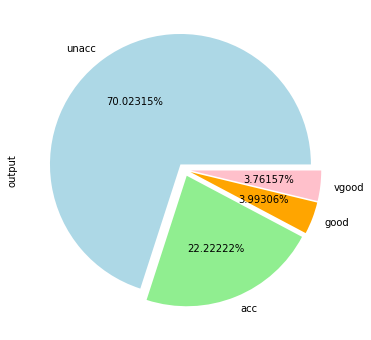

In [14]:
# 데이터셋 분포
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', 
                                   autopct='%0.05f%%', 
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'], 
                                   explode=(0.05, 0.05, 0.05,0.05))

- 허용 불가능한 데이터가 대부분(70%)

In [15]:
# 데이터를 범주형 타입으로 변환
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns: # 데이터를 범주형으로 변환
    dataset[category] = dataset[category].astype('category')

# 범주형 데이터의 단어를 숫자(넘파이 배열)로 변환
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

# 두 개 이상의 넘파이 객체를 합침
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10] # 합쳐진 넘파이 배열 중 10개의 행을 출력

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

- 범주형 데이터를 텐서로 변환하기 위한 절차
    - 범주형 데이터 -> category 변환 -> 넘파이 배열(numpy array) -> 텐서(Tensor)
- 파이토치로 모델을 학습하기 위해선 텐서 형태로 변환해야 하는데, 이는 넘파이 배열을 통해 가능
- cat.codes는 어떤 클래스가 어떤 숫자로 매핑되어 있는지 확인하기 어려움
- np.stack은 배열들을 새로운 축으로 합쳐 줌. 따라서 두 배열의 차원이 동일해야 함
    - ex> (2,2) 넘파이 배열 2개를 합치면 (2,2,2)
    - np.concatenate는 (2,2) 넘파이 배열 2개를 합치면 (4,2) -> axis=0

In [19]:
# 넘파이 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

C:\Users\tactics\AppData\Local\Temp/ipykernel_1440/262467741.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  categorical_data = torch.tensor(categorical_data, dtype=torch.int64)


tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [20]:
# 타겟 피쳐 텐서 변환
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


- get_dummies() : 문자를 숫자 (0,1) 즉 가변수(dummy variable)로 만들어 주는 함수

In [21]:
# 범주형 칼럼을 N차원으로 변환
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


- 워드 임베딩은 유사한 단어끼리 유사하게 인코딩되도록 표현하는 방법으로, 높은 차원의 임베딩일수록 단어 간의 세부적인 관계 파악 가능
    - 단일 숫자로 변환된 넘파이 배열을 N차원으로 변경하여 사용
- 배열을 N차원으로 변환하기 위해 먼저 모든 범주형 칼럼에 대한 임베딩 크기(벡터 차원)을 정의
    - 정해진 규칙은 없지만, 칼럼의 고유 값 수를 2로 나누는 것을 많이 사용

In [23]:
# 데이터셋 분리
total_records = 1728
test_records = int(total_records * .2) # 전체 데이터의 20%만 테스트 데이터로 활용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records : total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records : total_records]

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [24]:
# 모델의 네트워크 생성
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols 

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) # 넘파이의 concatenate와 같지만 대상이 텐서
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

- 클래스(class) 형태로 구현되는 모델은 nn.Module을 상속
- init()은 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며, 객체가 생성될 때 자동으로 호출
    - self : 첫 번째 파라미터는 self로 지정. 자기 자신을 의미
    - embedding_size : 범주형 칼럼의 임베딩 크기
    - output_size : 출력의 크기
    - layers : 모든 계층에 대한 목록
    - p : 드롭아웃(기본값 0.5)
- super().__init__()은 부모 클래스(Model 클래스)에 접근할 때 사용. super는 self를 사용 x
- 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가
    - Linear : 선형 계층(linear layer)은 입력 데이터에 선형 변환을 진행한 결과(y = Wx + b)
        - y : 선형 계층의 출력 값, W : 가중치, x : 입력 값, b : 바이어스
        - 선형 계층은 입력과 가중치를 곱한 후 바이어스를 더한 값
    - ReLU : 활성화 함수
    - BatchNorm1d : 배치 정규화(batch normalization) 용도로 사용
        - 신경망 안에서 데이터의 평균과 분산을 조정. 일반적으로 평균이 0, 분산이 1이 되도록 정규화
    - Dropout : 과적합 방지에 사용
- forward() : 학습 데이터를 입력받아서 연산을 진행. 모델 객체를 데이터와 함꼐 호출하면 자동으로 실행

In [26]:
# Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [28]:
# 모델의 파라미터 정의
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
# CPU/GPU 사용 지정
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [38]:
# 모델 학습
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).cuda()
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 aggregated_losses에 추가
    
    if i % 25 == 1:
        print(f'epoch: {i:3} loss : {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward() # 가중치를 업데이트하기 위해 손실 함수의 backward() 메서드 호출
    optimizer.step() # 옵티마이저 함수의 step() 메서드를 이용해 기울기 업데이트
    
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss : 1.52741945
epoch:  26 loss : 1.32650769
epoch:  51 loss : 1.24943876
epoch:  76 loss : 1.15718710
epoch: 101 loss : 1.03131664
epoch: 126 loss : 0.92791313
epoch: 151 loss : 0.79866332
epoch: 176 loss : 0.74244434
epoch: 201 loss : 0.68144894
epoch: 226 loss : 0.64707524
epoch: 251 loss : 0.62740403
epoch: 276 loss : 0.61667812
epoch: 301 loss : 0.60256380
epoch: 326 loss : 0.58737302
epoch: 351 loss : 0.58476651
epoch: 376 loss : 0.58816105
epoch: 401 loss : 0.57891464
epoch: 426 loss : 0.57420576
epoch: 451 loss : 0.57268906
epoch: 476 loss : 0.56818658
epoch: 500 loss: 0.5702716708


- 25 에포크마다 출력된 오차 정보 추출

In [40]:
# 테스트 데이터셋으로 모델 예측
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data).cuda()
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.55804962


- 훈련 데이터셋에서 도출된 손실 값과 비슷하므로 과적합은 발생하지 않았다고 판단 가능

In [41]:
# 모델의 예측 확인
print(y_val[:5])

tensor([[ 3.3786,  1.8727, -4.1513, -4.0648],
        [ 3.9461,  2.3306, -5.4539, -5.2170],
        [ 5.6013,  4.2029, -8.0732, -7.8284],
        [ 3.0972,  1.7590, -3.6641, -3.7088],
        [ 1.1371,  0.6732, -1.5635, -1.5018]], device='cuda:0')


- 모델 네트워크의 output_size=4이므로 출력층에 4개의 뉴런이 포함되어 출력
- 실제 출력이 0이면 인덱스 0(ex>3.3786)의 값이 인덱스 1(ex>1.8727)의 값보다 높아야 함

In [43]:
# 가장 큰 값을 갖는 인덱스 확인
y_val = y_val.cpu()
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


- 인덱스가 0인 값이 인덱스가 1인 값보다 크므로 처리된 출력이 0임을 확인

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 테스트 데이터셋을 이용한 정확도 확인
y_val = y_val.cpu()
test_outputs = test_outputs.cpu()

print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[258   1]
 [ 85   1]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.50      0.01      0.02        86

    accuracy                           0.75       345
   macro avg       0.63      0.50      0.44       345
weighted avg       0.69      0.75      0.65       345

0.7507246376811594
